In [1]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import string

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf


[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\I.V.SRICHANDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:

# Preprocess data function
def preprocess_data(text):
    user_name = '@[A-Za-z0-9]+'  # Pattern for matching the user names in the tweet
    has_tag = '#[A-Za-z0-9]+'  # Pattern for matching the hashtags in the tweet
    url = 'https?:\/\/[A-Za-z0-9\.\/\-]+'  # Pattern for matching the URLs in the tweet

    x = text.lower()  # Lower casing all the characters
    x = re.sub(user_name, '', x)  # Replace the username with an empty character
    x = re.sub(has_tag, '', x)  # Replace the hashtags with an empty character
    x = re.sub(url, '', x)  # Replace the URLs with an empty character
    x = x.translate(str.maketrans('', '', string.punctuation))  # Replace all the characters except alphabets and digits from the tweet

    return x


In [4]:
import pandas as pd
import re
import string
import tensorflow as tf
import numpy as np
import itertools

# Load training data
train_df = pd.read_csv("Tam-SA-train.csv")
train_df.head()

# Load validation data
valid_df = pd.read_csv("Tam-SA-val.csv")
valid_df.head()

# Load test data without labels
test_df = pd.read_csv("Tam-SA-test-without-labels.csv")


train_df["Text"] = train_df["Text"].apply(lambda x: preprocess_data(x))
valid_df["Text"] = valid_df["Text"].apply(lambda x: preprocess_data(x))
test_df["Text"] = test_df["Text"].apply(lambda x: preprocess_data(x))

In [5]:
train_label = train_df["Label"].tolist()
valid_label = valid_df["Label"].tolist()


In [6]:
class_names = list(set(train_label))
class_names

['Positive', 'Mixed_feelings', 'unknown_state', 'Negative']

In [7]:
class_dist = Counter(train_label)
class_dist

Counter({'Positive': 18145,
         'unknown_state': 5164,
         'Negative': 4151,
         'Mixed_feelings': 3662})

In [8]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
valid_label = le.fit_transform(valid_label)

In [9]:
le.inverse_transform([0,1,2,3])

array(['Mixed_feelings', 'Negative', 'Positive', 'unknown_state'],
      dtype='<U14')

In [10]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                }

class_weight

{0: 8.498634625887494,
 1: 7.497470489038786,
 2: 1.7151832460732985,
 3: 6.0267234701781565}

In [11]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [17]:
!pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
words_in_train = [sent.split() for sent in train_df["Text"]]
words_in_train[0:5]

[['ennq', 'pa', 'idhu', 'paei', 'padama', 'twist', 'nalla', 'irkkae'],
 ['na',
  'oru',
  'thalaivar',
  'veriyanintha',
  'padam',
  'pakanum',
  'innu',
  'nenaichenahna',
  'trailer',
  'pathuttu',
  'mudivu',
  'pannittenkandippa',
  'padam',
  'pakka',
  'matten'],
 ['last', 'shot', 'apdiye', 'moratu', 'kaala', 'paatha', 'feeling'],
 ['darbar', 'motion', 'poster', 'see', 'after', 'petta', 'trailer'],
 ['ln',
  '9',
  'minutes',
  '88k',
  'likes',
  'ajith',
  'sir',
  'fans',
  'like',
  'here']]

In [13]:
words_in_valid = [sent.split() for sent in valid_df["Text"] ]
words_in_valid[0:5]

[['just', '2k', 'likes', 'to', 'reach', '400k', 'likes\u200b'],
 ['massssssssssssssssssss', 'overload', 'sema', 'vera', 'level'],
 ['shes', 'looks', 'like', 'a', 'dummy', 'mom', 'ki', 'gudiya'],
 ['எந்த',
  'ட்ரைலர்',
  'சிறந்தது',
  'பிசாசு',
  'விருப்பம்',
  'சைக்கோ',
  'பதிவிடுங்கள்'],
 ['adichi', 'under', 'wear', 'oda', 'oda', 'vituruvean', 'lol']]

In [14]:
words_in_test = [sent.split() for sent in test_df['Text']] 
words_in_test[0:5]

[['thalaivan', 'oruvane', 'thalapathy', 'matume', 'mass', 'thalaivaa'],
 ['kandipaga',
  'tamilnadu',
  'arasiyal',
  'kizhikaraa',
  'padam',
  'thaan',
  'ithu'],
 ['for',
  'ajith',
  'actinghaha',
  'for',
  'vijay',
  'over',
  'actinghahahahaaha',
  'hahahaha',
  'hahahahaaha',
  'hahahaha',
  'hahahaa',
  'hahahahhahahaaha',
  'hahahahhahahaaha',
  'hahahhahahahhahahahahahahahhahaha',
  'hahahahahahhahahaha',
  'hahahahahahahaha',
  'hahahahahahaha',
  'hahahahahahahaha'],
 ['உண்மையா',
  'லவ்',
  'பண்ணி',
  'வீட்ல',
  'சம்மதிக்கலனா',
  'என்ன',
  'பண்ண',
  'அந்த',
  'பொண்ணுக்காக',
  'உயிரகுடுக்கிற',
  'அளவு',
  'லவ்',
  'பண்ணா',
  'தப்பா',
  'யாரோ',
  'ஒருத்தர்',
  'பன்ற',
  'தப்பால',
  'உண்மையா',
  'லவ்',
  'பன்றவங்களுக்கும்',
  'பாதிக்கிதுல',
  'ஆணவ',
  'கொலை',
  'அதிகமாக',
  'மேல்',
  'சாதினு',
  'சொல்லிக்கிற',
  'அவங்களால',
  'தான்',
  'அதிகமா',
  'நடக்குது'],
 ['chiiiiiii',
  'mokka',
  'punda',
  'trailer',
  'wigpathy',
  'sura',
  '2',
  'next',
  'flop',
  'is',
  'ready

In [15]:
all_words_train = list(itertools.chain(*words_in_train)) 
all_words_train[0:10]

['ennq',
 'pa',
 'idhu',
 'paei',
 'padama',
 'twist',
 'nalla',
 'irkkae',
 'na',
 'oru']

In [16]:
all_words_valid = list(itertools.chain(*words_in_valid)) 
all_words_valid[0:10]

['just',
 '2k',
 'likes',
 'to',
 'reach',
 '400k',
 'likes\u200b',
 'massssssssssssssssssss',
 'overload',
 'sema']

In [17]:
all_words_test = list(itertools.chain(*words_in_test)) 
all_words_test[0:10]

['thalaivan',
 'oruvane',
 'thalapathy',
 'matume',
 'mass',
 'thalaivaa',
 'kandipaga',
 'tamilnadu',
 'arasiyal',
 'kizhikaraa']

In [18]:
word_counts_train = collections.Counter(all_words_train)  
word_counts_train.most_common(15)

[('like', 3332),
 ('thala', 2992),
 ('trailer', 2359),
 ('mass', 2296),
 ('vera', 2253),
 ('படம்', 1982),
 ('la', 1971),
 ('level', 1896),
 ('padam', 1883),
 ('da', 1828),
 ('movie', 1727),
 ('fans', 1673),
 ('வாழ்த்துக்கள்', 1597),
 ('ah', 1543),
 ('super', 1451)]

In [19]:
word_counts_valid = collections.Counter(all_words_valid)  
word_counts_valid.most_common(15)

[('like', 417),
 ('thala', 332),
 ('trailer', 312),
 ('vera', 272),
 ('la', 268),
 ('mass', 267),
 ('padam', 241),
 ('da', 239),
 ('level', 231),
 ('படம்', 230),
 ('movie', 220),
 ('வாழ்த்துக்கள்', 205),
 ('anna', 188),
 ('ah', 186),
 ('fans', 182)]

In [20]:
word_counts_test = collections.Counter(all_words_test)  
word_counts_test.most_common(15)

[('like', 348),
 ('thala', 346),
 ('vera', 271),
 ('trailer', 256),
 ('mass', 250),
 ('padam', 219),
 ('movie', 216),
 ('படம்', 214),
 ('da', 207),
 ('level', 207),
 ('la', 192),
 ('fans', 185),
 ('வாழ்த்துக்கள்', 181),
 ('ah', 161),
 ('super', 160)]

In [21]:
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

     words  count
0     like   3332
1    thala   2992
2  trailer   2359
3     mass   2296
4     vera   2253


In [22]:
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

     words  count
0     like    417
1    thala    332
2  trailer    312
3     vera    272
4       la    268


In [23]:
words_with_counts_test = pd.DataFrame(word_counts_test.most_common(len(all_words_test)), columns=['words', 'count']) 
print(words_with_counts_test.head())

     words  count
0     like    348
1    thala    346
2     vera    271
3  trailer    256
4     mass    250


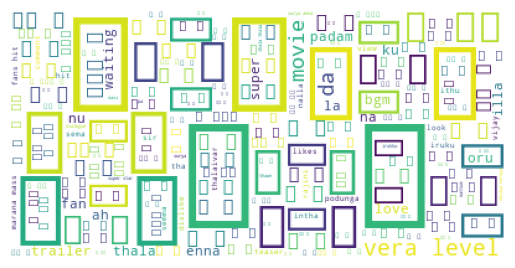

In [24]:
text = " ".join(all_words_train)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

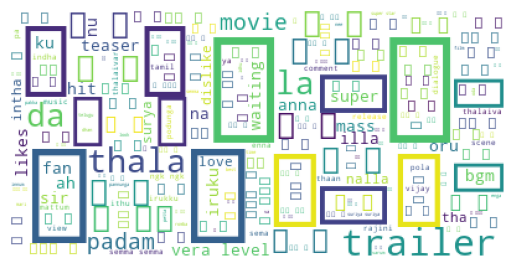

In [25]:
text = " ".join(all_words_valid)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

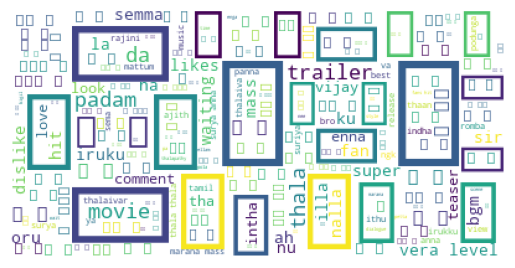

In [26]:
text = " ".join(all_words_test)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [28]:
train_text = train_df['Text'].tolist()
valid_text = valid_df['Text'].tolist()
test_text = test_df['Text'].tolist()

train_label = train_df['Label'].tolist()
valid_label = valid_df['Label'].tolist()

In [29]:
all_words = all_words_train + all_words_valid 
corpus = train_text + valid_text
vocab_size = len(set(all_words)) 
embedding_dim = 100 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>" 

In [30]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [31]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')

train_padded = np.concatenate((training_padded, valid_padded), axis=0)

test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [32]:
METRICS = [

      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [33]:
filter_size = 128
kernel_size = 5
pool_size = 5


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()

C:\Users\I.V.SRICHANDRA\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 178, 100)       │     7,115,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 178, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,222,956 (27.55 MB)

 Trainable params: 7,222,956 (27.55 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 100
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    batch_size = 32,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    validation_split=0.1,
    class_weight=class_weight
)


Epoch 1/100
973/973 ━━━━━━━━━━━━━━━━━━━━ 98s 97ms/step - accuracy: 0.7782 - auc: 0.6601 - loss: 5.2895 - precision: 0.8075 - recall: 0.1317 - val_accuracy: 0.7765 - val_auc: 0.5787 - val_loss: 1.4267 - val_precision: 0.9016 - val_recall: 0.1192
Epoch 2/100
973/973 ━━━━━━━━━━━━━━━━━━━━ 98s 101ms/step - accuracy: 0.7992 - auc: 0.7280 - loss: 5.0054 - precision: 0.8304 - recall: 0.2480 - val_accuracy: 0.7533 - val_auc: 0.6467 - val_loss: 1.3164 - val_precision: 0.6835 - val_recall: 0.0247
Epoch 3/100
973/973 ━━━━━━━━━━━━━━━━━━━━ 130s 89ms/step - accuracy: 0.7807 - auc: 0.7307 - loss: 4.9917 - precision: 0.7319 - recall: 0.1917 - val_accuracy: 0.7935 - val_auc: 0.6954 - val_loss: 1.2329 - val_precision: 0.8106 - val_recall: 0.2272
Epoch 4/100
973/973 ━━━━━━━━━━━━━━━━━━━━ 83s 85ms/step - accuracy: 0.7942 - auc: 0.7235 - loss: 4.9779 - precision: 0.7985 - recall: 0.2364 - val_accuracy: 0.7976 - val_auc: 0.6933 - val_loss: 1.2483 - val_precision: 0.7616 - val_recall: 0.2769
Epoch 5/100
973/97

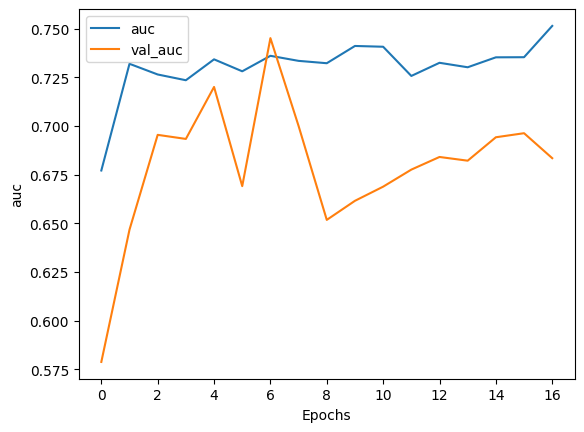

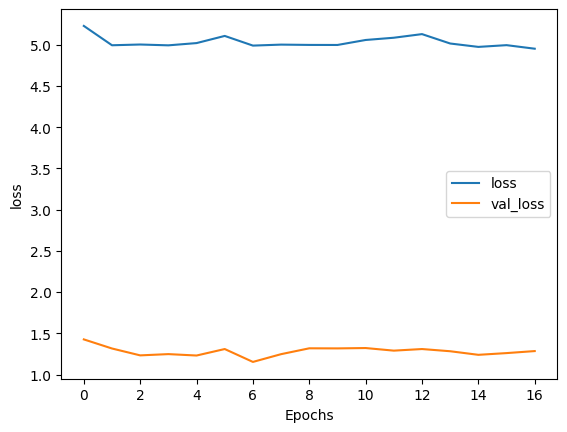

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [37]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))


from sklearn.metrics import classification_report
y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(validation_labels, axis=1)
# print(classification_report(y_true, y_pred))
# precision, recall, f1-score, support
pr=precision_score(y_true, y_pred, average='macro')
rc=recall_score(y_true, y_pred, average='macro')
f1=f1_score(y_true, y_pred, average='macro')
print("Precision: ", pr)
print("Recall: ", rc)
print("F1-Score: ", f1)



121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8116 - auc: 0.7445 - loss: 1.1571 - precision: 0.7713 - recall: 0.3511
Loss = 1.1536071300506592
Accuracy = 80.71%
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Precision:  0.38079612141037733
Recall:  0.3544763372041528
F1-Score:  0.3520233559540011


In [38]:
# model.save('model_tamil.h5')

In [40]:
# predict the labels on test dataset

predictions = model.predict(test_padded)
predictions = np.argmax(predictions, axis = 1)
predictions = le.inverse_transform(predictions)
test_df["Label"] = predictions
test_df.to_csv("tamil_test_labels_1.csv", index=False)



109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
